# Convergence Plot

### Authors : Daniel Luna (UFRN), Vicente Sousa (UFRN) e Ricardo Queiroz (UFRN)

## Directory

In [27]:
# Changing Working Directory - Linux
results_path = '/home/oai-ufrn/Repositories/tests/open_ran_datacenter_placement/Results/results_Placement_Manaus_Case_1_2_odcs/'
campaing_path = '/home/oai-ufrn/Repositories/tests/open_ran_datacenter_placement/teste/Placement_Natal_Case_1_2/'
plots_result_path = '/home/oai-ufrn/Repositories/tests/open_ran_datacenter_placement/Plots/'
%cd $plots_result_path

/home/oai-ufrn/Repositories/tests/open_ran_datacenter_placement/Plots


## Script

In [28]:
!mkdir "PlotScripts"
%cd $plots_result_path"PlotScripts"

mkdir: cannot create directory ‘PlotScripts’: File exists
/home/oai-ufrn/Repositories/tests/open_ran_datacenter_placement/Plots/PlotScripts


In [29]:
%%file ConvergencePlot.py
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Wed Oct  2 16:03:59 2019

@author: daniel
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import seaborn as sns
import scipy.stats as sci
import scipy.stats as st
import warnings
warnings.filterwarnings("ignore")
from itertools import cycle
import os
import argparse
import yaml 
from random import randint   
import itertools
import pandas as pd
import plotly.graph_objects as go
import plotly.express as px
import plotly.io as pio

class openSimulation:
    def __init__(self, configurations_file):
        self.email_to = 'fulano@gmail.com'            
        with open(configurations_file, 'r') as f:
            self.doc = yaml.load(f, Loader=yaml.loader.BaseLoader)
            #self.doc = doc
        self.campaign_name = os.path.splitext(configurations_file)[0]
        
         # Simu parameters
        self.commandScript = ''
        for iscenarioParameters in self.doc['scenarioParameters'].items():
            commandraw= " --"+str(iscenarioParameters[0])+"="+str(iscenarioParameters[1][0])
            self.commandScript = self.commandScript + commandraw
        #teste = self.commandScript.split(' ')
        #print(teste[2].split('=')[1])

        #Plot parameters
        self.showPlot = True
        self.plotCI = False
        self.JobsConvergence = False
        self.window = 0.1 # window of 1ms

        # ns-3 script configuration
        self.script = str(self.doc['ScriptParameters']['script'])
        self.local_path = str(self.doc['ScriptParameters']['local_path'])
        self.plot_path = os.getcwd()
        #self.local_path = os.getcwd() + '/' + self.local_path
        self.cluster_path = str(self.doc['ScriptParameters']['cluster_path'])
        self.outputDirName = str(self.doc['ScriptParameters']['outputDir'][0])
        self.outputDir = str(self.doc['ScriptParameters']['outputDir'][1])
        self.seed = str(self.doc['ScriptParameters']['seed'])
        self.CampaignTag = str(self.doc['ScriptParameters']['CampaignTag'])
        self.configurations_file = configurations_file       
        self.simLocation = str(self.doc['ScriptParameters']['simLocation'])

        # Shell Script Parameters configuration
        self.nOfCurlines=self.doc['ShellScriptParameters']['nOfCurlines']
        self.SimTied = self.doc['ShellScriptParameters']['SimTied']
        self.nOfCurlinesTied = self.doc['ShellScriptParameters']['nOfCurlinesTied']
        self.daytime  = self.doc['ShellScriptParameters']['daytime']
        self.htime  = self.doc['ShellScriptParameters']['htime']
        self.ntasks = self.doc['ShellScriptParameters']['ntasks']
        self.cpusPerTask = self.doc['ShellScriptParameters']['cpusPerTask']
        self.numberOfJobsShellScript = int(self.doc['ShellScriptParameters']['numberOfJobsShellScript'])
        
         #Lines/curves
        self.campaignX = self.doc['campaignLines']['campaignX']
        self.campaignLines = self.doc['campaignLines']['campaignLines']
        self.nJobs = int(self.doc['campaignLines']['jobs'])

    def VetorMediaAll (self, vetor,janela):
        NewVetorMedia = []
        VetorMedia=[]
        VetorVar=[]
        VetorMoment3=[]
        VetorMoment4=[]
        VetorVpp=[]
        VetorCorr=[]
        #media = np.mean(vetor[0:janela])
        #NewVetorMedia.append(np.ones(janela)*media)
        for i in range(0,len(vetor),janela):
            media = np.mean(vetor[i:i+janela])
            VetorMedia = np.append(VetorMedia,media)
            
            variancia = np.var(vetor[i:i+janela])
            VetorVar=np.append(VetorVar,variancia)
            
            momento3 = sci.moment(vetor[i:i+janela],moment=3)
            VetorMoment3=np.append(VetorMoment3,momento3)
            
            momento4 = sci.moment(vetor[i:i+janela],moment=4)
            VetorMoment4=np.append(VetorMoment4,momento4)
            
            vpp = np.max(vetor[i:i+janela]) - np.min(vetor[i:i+janela])
            VetorVpp=np.append(VetorVpp,vpp)
            
            corr = vetor[i:i+janela].dot(np.conj(vetor[i:i+janela]))
            VetorCorr=np.append(VetorCorr,corr)
            
            NewVetorMedia=np.concatenate((NewVetorMedia,np.ones(janela)*media),axis=0)
        return NewVetorMedia,VetorMedia,VetorVar,VetorMoment3,VetorMoment4,VetorVpp,VetorCorr
    
    def plotCampaign(self,curCampaign, metric,jobs):
        outputDir = self.plot_path
        njobs = min(jobs,self.nJobs)
        m_plr, m_plrCI, m_tput, m_tputCI, m_pkt, m_pktCI = [], [], [], [], [], []
        m_tput1,m_tput2=[],[]
        m_tputCI1,m_tputCI2,m_tputCI3,m_tputCI4=[],[],[],[]
        m_tputCI5,m_tputCI6,m_tputCI7,m_tputCI8=[],[],[],[]
        m_tputCI9,m_tputCI10=[],[]
        markers_on_all = cycle(list(itertools.product([0], [1,2,3,4,5])))
        markersA = cycle(('o','v', 'D', '>', 'h', '^', '*', '>', 's', 'H', 'D', 'd'))
        colors = cycle(('b', 'g', 'r', 'c', 'm', 'y', 'k'))
        linestyle = cycle(('-', '--'))# '-.', ':'))                    
        ls_plotly = cycle(("solid","dot","dash","longdash","dashdot","longdashdot")) 
        dfMeanTput = pd.DataFrame()
        dfMeanPlr = pd.DataFrame()
        dfMeanRxPkt = pd.DataFrame()    
        nOfCurlines=int(self.nOfCurlines[0]) # number of Campaign Lines in 1 simulation (max value = 3)
        SimTied = int(self.SimTied[0]) # whether or not the simulation parameters are tied (0 or 1)
        nOfCurlinesTied = int(self.nOfCurlinesTied[0]) # number of Campaign Lines tied (max value = nOfCurlines)
        print (nOfCurlines, SimTied,nOfCurlinesTied)
        if nOfCurlines == 1 and SimTied == 0:
            legend=[]
            legendSims=[]
            color=next(colors)
            marker=next(markersA)
            markers_on=next(markers_on_all)
            linestyle_on =next(linestyle)
            ls_plotly_on = next(ls_plotly)
            curline = self.campaignLines[0]
            campaignX = self.campaignX[0]
            dfMovingMeanAllSims=pd.DataFrame()
            dfMeanAllSims = pd.DataFrame()
            vtLastTimeValueAllSims = []
            isim = 0
            for i in range(len(self.doc['scenarioParameters'][curline])):
                for iCampaignX in range(len(self.doc['scenarioParameters'][campaignX])):
                    df=pd.DataFrame()
                    dfMovingMean=pd.DataFrame()
                    vtLastTimeValue=[]
                    if metric.split('-')[1] == 'PHY':
                        if metric.split('-')[2] == 'SimTime':
                            for iJob in range(0,njobs):
                                if metric.split('-')[3] == 'NR':
                                    vtMean = []
                                    if self.UlMode: 
                                        filepath = outputDir +"/JOB"+str(iJob)+"/Sim_"+str(isim)+"/GnbRxPacketTrace.txt"
                                    else:
                                        filepath = outputDir +"/JOB"+str(iJob)+"/Sim_"+str(isim)+"/UeRxPacketTrace.txt"
                                    df = pd.read_csv(filepath,sep='\t',index_col=False)
                                    df2 = pd.DataFrame(df, columns=['Time','tbSize','SINR(dB)'])
                                    timeLastValue = df['Time'][len(df['Time'])-1]
                                elif metric.split('-')[3] == 'LTE':
                                    vtMean = []
                                    if self.UlMode: 
                                        print('To be implemented')
                                    elif not(self.UlMode) and metric.split('-')[0] == 'Tput':
                                        filepath = outputDir +"/JOB"+str(iJob)+"/Sim_"+str(isim)+"/DlRxPhyStats.txt"
                                        df = pd.read_csv(filepath,sep='\t',index_col=False)
                                    elif not(self.UlMode) and metric.split('-')[0] == 'SINR':    
                                        filepath = outputDir +"/JOB"+str(iJob)+"/Sim_"+str(isim)+"/DlRsrpSinrStats.txt"
                                        df = pd.read_csv(filepath,sep='\t',index_col=False)
                                        df['SINR(dB)']=10*np.log10(df['sinr'])
                                    
                                    df = df.rename({'% time': 'Time'},axis=1)
                                    df2 = pd.DataFrame(df, columns=['Time','tbSize','SINR(dB)'])
                                    
                                    timeLastValue = df['Time'][len(df['Time'])-1]
                                
                                if metric.split('-')[0] == 'Tput': ## Calculate the PHY Throughput    
                                    df2.dropna(inplace=True)    
                                    ylabelpart2 = ' (kbps)'
                                    ndf2ShapePos0 = df2.shape[0]
                                    self.window=0.1
                                    WindowSize=len(df2[df2['Time']<=  df2.Time[0] + self.window])
                                    WindowSizeH = WindowSize
                                    WindowSizeL =0
                                    while ndf2ShapePos0 != WindowSizeH:
                                        if WindowSize == 0:
                                            medias = 0
                                        else:
                                            [vetor,medias,variancia,moment3,moment4,vpp,correlacao] = self.VetorMediaAll(df2.tbSize[WindowSizeL:WindowSizeH].values,WindowSize)
                                        vtMean = np.append(vtMean, medias);
                                        self.window+=0.1
                                        WindowSizeL = WindowSize
                                        WindowSizeH=len(df2[df2['Time']<=  df2.Time[0] + self.window])
                                        WindowSize = WindowSizeH - WindowSizeL
                                    
                                    vtMeandf = pd.DataFrame(vtMean)
                                    dfMovingMean = pd.concat([dfMovingMean,vtMeandf], axis=1)
                                    vtLastTimeValue = np.append(vtLastTimeValue,timeLastValue)
                                elif metric.split('-')[0] == 'SINR': ## Calculate the PHY SINR
                                    df2.dropna(inplace=True)    
                                    ylabelpart2 = ' (dB)'
                                    ndf2ShapePos0 = df2.shape[0]
                                    self.window=0.1
                                    WindowSize=len(df2[df2['Time']<=  df2.Time[0] + self.window])
                                    WindowSizeH = WindowSize
                                    WindowSizeL =0
                                    while ndf2ShapePos0 != WindowSizeH:
                                        if WindowSize == 0:
                                            medias = 0
                                        else:
                                            [vetor,medias,variancia,moment3,moment4,vpp,correlacao] = self.VetorMediaAll(10**(df2['SINR(dB)'][WindowSizeL:WindowSizeH].values/10),WindowSize)
                                        vtMean = np.append(vtMean, 10*np.log10(medias))
                                        self.window+=0.1
                                        WindowSizeL = WindowSize
                                        WindowSizeH=len(df2[df2['Time']<=  df2.Time[0] + self.window])
                                        WindowSize = WindowSizeH - WindowSizeL
                                    
                                    vtMeandf = pd.DataFrame(vtMean)
                                    dfMovingMean = pd.concat([dfMovingMean,vtMeandf], axis=1)
                                    vtLastTimeValue = np.append(vtLastTimeValue,timeLastValue)

                                    
                            vtLastTimeValueAllSims = np.append(vtLastTimeValueAllSims,vtLastTimeValue.mean())
                            if metric.split('-')[0] == 'Tput':
                                dfMovingMeanAllSims = pd.concat([dfMovingMeanAllSims,dfMovingMean.dropna().mean(axis=1)/0.1], axis=1) # dividing by the window to calcutate tput
                            elif metric.split('-')[0] == 'SINR':
                                dfMovingMeanAllSims = pd.concat([dfMovingMeanAllSims,dfMovingMean.dropna().mean(axis=1)], axis=1)
                        elif metric.split('-')[2] == 'Jobs':
                            vtMeanJobs = []
                            for iJob in range(0,njobs):
                                if metric.split('-')[3] == 'NR':
                                    vtMean = []
                                    if self.UlMode: 
                                        filepath = outputDir +"/JOB"+str(iJob)+"/Sim_"+str(isim)+"/GnbRxPacketTrace.txt"
                                    else:
                                        filepath = outputDir +"/JOB"+str(iJob)+"/Sim_"+str(isim)+"/UeRxPacketTrace.txt"
                                    df = pd.read_csv(filepath,sep='\t',index_col=False)
                                    df2 = pd.DataFrame(df, columns=['Time','tbSize','SINR(dB)'])
                                    timeLastValue = df['Time'][len(df['Time'])-1]
                                elif metric.split('-')[3] == 'LTE':
                                    vtMean = []
                                    if self.UlMode: 
                                        print('To be implemented')
                                    elif not(self.UlMode) and metric.split('-')[0] == 'Tput':
                                        filepath = outputDir +"/JOB"+str(iJob)+"/Sim_"+str(isim)+"/DlRxPhyStats.txt"
                                        df = pd.read_csv(filepath,sep='\t',index_col=False)
                                    elif not(self.UlMode) and metric.split('-')[0] == 'SINR':    
                                        filepath = outputDir +"/JOB"+str(iJob)+"/Sim_"+str(isim)+"/DlRsrpSinrStats.txt"
                                        df = pd.read_csv(filepath,sep='\t',index_col=False)
                                        df['SINR(dB)']=10*np.log10(df['sinr'])
                                    
                                    df = df.rename({'% time': 'Time'},axis=1)
                                    df2 = pd.DataFrame(df, columns=['Time','tbSize','SINR(dB)'])
                                if metric.split('-')[0] == 'Tput':
                                    ylabelpart2 = '(kbps)'
                                    vtMeanJobs = np.append(vtMeanJobs, df2['tbSize'].sum()/df2.iloc[-1,0]/1000) #kbps
                                elif metric.split('-')[0] == 'SINR':
                                    ylabelpart2 = '(dB)'
                                    vtMeanJobs = np.append(vtMeanJobs,10*np.log10(np.mean(10**(df2['SINR(dB)']/10)))) #dB
                            dfMeanJobs = pd.DataFrame(vtMeanJobs)
                            dfMeanAllSims = pd.concat([dfMeanAllSims,dfMeanJobs], axis=1)  
                    isim +=1
            #Legend of 2/0/0
            for ilegend in self.doc['scenarioParameters'][curline]:
                legendEntry = self.CampaignTag + ": " + curline + " " + ilegend
                legend.append(legendEntry) 
                for ilegendcdf in self.doc['scenarioParameters'][campaignX]:
                    legendSimsEntry = legendEntry + "," + " " + campaignX + " " + ilegendcdf 
                    legendSims.append(legendSimsEntry)
        elif nOfCurlines==2 and SimTied == 0:
            legend=[]
            legendSims=[]
            color=next(colors)
            marker=next(markersA)
            markers_on=next(markers_on_all)
            linestyle_on =next(linestyle)
            ls_plotly_on = next(ls_plotly)
            curline = self.campaignLines[0]
            curline2 = self.campaignLines[1]
            campaignX = self.campaignX[0]
            dfMovingMeanAllSims=pd.DataFrame()
            dfMeanAllSims = pd.DataFrame()
            vtLastTimeValueAllSims = []
            isim = 0
            for i in range(len(self.doc['scenarioParameters'][curline])):
                for j in range(len(self.doc['scenarioParameters'][curline2])):
                    for iCampaignX in range(len(self.doc['scenarioParameters'][campaignX])):
                        df=pd.DataFrame()
                        dfMovingMean=pd.DataFrame()
                        vtLastTimeValue=[]
                        if metric.split('-')[1] == 'PHY':
                            if metric.split('-')[2] == 'SimTime':
                                for iJob in range(0,njobs):
                                    if metric.split('-')[3] == 'NR':
                                        vtMean = []
                                        if self.UlMode: 
                                            filepath = outputDir +"/JOB"+str(iJob)+"/Sim_"+str(isim)+"/GnbRxPacketTrace.txt"
                                        else:
                                            filepath = outputDir +"/JOB"+str(iJob)+"/Sim_"+str(isim)+"/UeRxPacketTrace.txt"
                                        df = pd.read_csv(filepath,sep='\t',index_col=False)
                                        df2 = pd.DataFrame(df, columns=['Time','tbSize','SINR(dB)'])
                                        timeLastValue = df['Time'][len(df['Time'])-1]
                                    elif metric.split('-')[3] == 'LTE':
                                        vtMean = []
                                        if self.UlMode: 
                                            print('To be implemented')
                                        elif not(self.UlMode) and metric.split('-')[0] == 'Tput':
                                            filepath = outputDir +"/JOB"+str(iJob)+"/Sim_"+str(isim)+"/DlRxPhyStats.txt"
                                            df = pd.read_csv(filepath,sep='\t',index_col=False)
                                        elif not(self.UlMode) and metric.split('-')[0] == 'SINR':    
                                            filepath = outputDir +"/JOB"+str(iJob)+"/Sim_"+str(isim)+"/DlRsrpSinrStats.txt"
                                            df = pd.read_csv(filepath,sep='\t',index_col=False)
                                            df['SINR(dB)']=10*np.log10(df['sinr'])
                                        
                                        df = df.rename({'% time': 'Time'},axis=1)
                                        df2 = pd.DataFrame(df, columns=['Time','tbSize','SINR(dB)'])
                                        
                                        timeLastValue = df['Time'][len(df['Time'])-1]
                                    
                                    if metric.split('-')[0] == 'Tput': ## Calculate the PHY Throughput    
                                        df2.dropna(inplace=True)    
                                        ylabelpart2 = ' (kbps)'
                                        ndf2ShapePos0 = df2.shape[0]
                                        self.window=0.1
                                        WindowSize=len(df2[df2['Time']<=  df2.Time[0] + self.window])
                                        WindowSizeH = WindowSize
                                        WindowSizeL =0
                                        while ndf2ShapePos0 != WindowSizeH:
                                            if WindowSize == 0:
                                                medias = 0
                                            else:
                                                [vetor,medias,variancia,moment3,moment4,vpp,correlacao] = self.VetorMediaAll(df2.tbSize[WindowSizeL:WindowSizeH].values,WindowSize)
                                            vtMean = np.append(vtMean, medias);
                                            self.window+=0.1
                                            WindowSizeL = WindowSize
                                            WindowSizeH=len(df2[df2['Time']<=  df2.Time[0] + self.window])
                                            WindowSize = WindowSizeH - WindowSizeL
                                        
                                        vtMeandf = pd.DataFrame(vtMean)
                                        dfMovingMean = pd.concat([dfMovingMean,vtMeandf], axis=1)
                                        vtLastTimeValue = np.append(vtLastTimeValue,timeLastValue)
                                    elif metric.split('-')[0] == 'SINR': ## Calculate the PHY SINR
                                        df2.dropna(inplace=True)    
                                        ylabelpart2 = ' (dB)'
                                        ndf2ShapePos0 = df2.shape[0]
                                        self.window=0.1
                                        WindowSize=len(df2[df2['Time']<=  df2.Time[0] + self.window])
                                        WindowSizeH = WindowSize
                                        WindowSizeL =0
                                        while ndf2ShapePos0 != WindowSizeH:
                                            if WindowSize == 0:
                                                medias = 0
                                            else:
                                                [vetor,medias,variancia,moment3,moment4,vpp,correlacao] = self.VetorMediaAll(10**(df2['SINR(dB)'][WindowSizeL:WindowSizeH].values/10),WindowSize)
                                            vtMean = np.append(vtMean, 10*np.log10(medias))
                                            self.window+=0.1
                                            WindowSizeL = WindowSize
                                            WindowSizeH=len(df2[df2['Time']<=  df2.Time[0] + self.window])
                                            WindowSize = WindowSizeH - WindowSizeL
                                        
                                        vtMeandf = pd.DataFrame(vtMean)
                                        dfMovingMean = pd.concat([dfMovingMean,vtMeandf], axis=1)
                                        vtLastTimeValue = np.append(vtLastTimeValue,timeLastValue)
    
                                        
                                vtLastTimeValueAllSims = np.append(vtLastTimeValueAllSims,vtLastTimeValue.mean())
                                if metric.split('-')[0] == 'Tput':
                                    dfMovingMeanAllSims = pd.concat([dfMovingMeanAllSims,dfMovingMean.dropna().mean(axis=1)/0.1], axis=1) # dividing by the window to calcutate tput
                                elif metric.split('-')[0] == 'SINR':
                                    dfMovingMeanAllSims = pd.concat([dfMovingMeanAllSims,dfMovingMean.dropna().mean(axis=1)], axis=1)
                            elif metric.split('-')[2] == 'Jobs':
                                vtMeanJobs = []
                                for iJob in range(0,njobs):
                                    if metric.split('-')[3] == 'NR':
                                        vtMean = []
                                        if self.UlMode: 
                                            filepath = outputDir +"/JOB"+str(iJob)+"/Sim_"+str(isim)+"/GnbRxPacketTrace.txt"
                                        else:
                                            filepath = outputDir +"/JOB"+str(iJob)+"/Sim_"+str(isim)+"/UeRxPacketTrace.txt"
                                        df = pd.read_csv(filepath,sep='\t',index_col=False)
                                        df2 = pd.DataFrame(df, columns=['Time','tbSize','SINR(dB)'])
                                        timeLastValue = df['Time'][len(df['Time'])-1]
                                    elif metric.split('-')[3] == 'LTE':
                                        vtMean = []
                                        if self.UlMode: 
                                            print('To be implemented')
                                        elif not(self.UlMode) and metric.split('-')[0] == 'Tput':
                                            filepath = outputDir +"/JOB"+str(iJob)+"/Sim_"+str(isim)+"/DlRxPhyStats.txt"
                                            df = pd.read_csv(filepath,sep='\t',index_col=False)
                                        elif not(self.UlMode) and metric.split('-')[0] == 'SINR':    
                                            filepath = outputDir +"/JOB"+str(iJob)+"/Sim_"+str(isim)+"/DlRsrpSinrStats.txt"
                                            df = pd.read_csv(filepath,sep='\t',index_col=False)
                                            df['SINR(dB)']=10*np.log10(df['sinr'])
                                        
                                        df = df.rename({'% time': 'Time'},axis=1)
                                        df2 = pd.DataFrame(df, columns=['Time','tbSize','SINR(dB)'])
                                    if metric.split('-')[0] == 'Tput':
                                        ylabelpart2 = '(kbps)'
                                        vtMeanJobs = np.append(vtMeanJobs, df2['tbSize'].sum()/df2.iloc[-1,0]/1000) #kbps
                                    elif metric.split('-')[0] == 'SINR':
                                        ylabelpart2 = '(dB)'
                                        vtMeanJobs = np.append(vtMeanJobs,10*np.log10(np.mean(10**(df2['SINR(dB)']/10)))) #dB
                                dfMeanJobs = pd.DataFrame(vtMeanJobs)
                                dfMeanAllSims = pd.concat([dfMeanAllSims,dfMeanJobs], axis=1)  
                        isim +=1

             #Labels of 2/0/0
            for ilegend in self.doc['scenarioParameters'][curline]:
                legendtag = self.CampaignTag + ": " + curline + " " + ilegend
                for ilegend2 in self.doc['scenarioParameters'][curline2]:
                    legendtag2 = legendtag + ", " + curline2 + " " + ilegend2
                    for ilegendcdf in self.doc['scenarioParameters'][campaignX]:
                        legendSimsEntry = legendtag2 + "," + " " + campaignX + " " + ilegendcdf 
                        legendSims.append(legendSimsEntry)
        elif nOfCurlines==3 and SimTied == 0:
            plegend=[]
            legendSims=[]
            color=next(colors)
            marker=next(markersA)
            markers_on=next(markers_on_all)
            linestyle_on =next(linestyle)
            ls_plotly_on = next(ls_plotly)
            curline = self.campaignLines[0]
            curline2 = self.campaignLines[1]
            curline3 = self.campaignLines[2]
            campaignX = self.campaignX[0]
            dfMovingMeanAllSims=pd.DataFrame()
            dfMeanAllSims = pd.DataFrame()
            vtLastTimeValueAllSims = []
            isim = 0
            for i in range(len(self.doc['scenarioParameters'][curline])):
                for j in range(len(self.doc['scenarioParameters'][curline2])):
                    for k in range(len(self.doc['scenarioParameters'][curline3])):
                        for iCampaignX in range(len(self.doc['scenarioParameters'][campaignX])):
                            df=pd.DataFrame()
                            dfMovingMean=pd.DataFrame()
                            vtLastTimeValue=[]
                            if metric.split('-')[1] == 'PHY':
                                if metric.split('-')[2] == 'SimTime':
                                    for iJob in range(0,njobs):
                                        if metric.split('-')[3] == 'NR':
                                            vtMean = []
                                            if self.UlMode: 
                                                filepath = outputDir +"/JOB"+str(iJob)+"/Sim_"+str(isim)+"/GnbRxPacketTrace.txt"
                                            else:
                                                filepath = outputDir +"/JOB"+str(iJob)+"/Sim_"+str(isim)+"/UeRxPacketTrace.txt"
                                            df = pd.read_csv(filepath,sep='\t',index_col=False)
                                            df2 = pd.DataFrame(df, columns=['Time','tbSize','SINR(dB)'])
                                            timeLastValue = df['Time'][len(df['Time'])-1]
                                        elif metric.split('-')[3] == 'LTE':
                                            vtMean = []
                                            if self.UlMode: 
                                                print('To be implemented')
                                            elif not(self.UlMode) and metric.split('-')[0] == 'Tput':
                                                filepath = outputDir +"/JOB"+str(iJob)+"/Sim_"+str(isim)+"/DlRxPhyStats.txt"
                                                df = pd.read_csv(filepath,sep='\t',index_col=False)
                                            elif not(self.UlMode) and metric.split('-')[0] == 'SINR':    
                                                filepath = outputDir +"/JOB"+str(iJob)+"/Sim_"+str(isim)+"/DlRsrpSinrStats.txt"
                                                df = pd.read_csv(filepath,sep='\t',index_col=False)
                                                df['SINR(dB)']=10*np.log10(df['sinr'])
                                            
                                            df = df.rename({'% time': 'Time'},axis=1)
                                            df2 = pd.DataFrame(df, columns=['Time','tbSize','SINR(dB)'])
                                            
                                            timeLastValue = df['Time'][len(df['Time'])-1]
                                        
                                        if metric.split('-')[0] == 'Tput': ## Calculate the PHY Throughput    
                                            df2.dropna(inplace=True)    
                                            ylabelpart2 = ' (kbps)'
                                            ndf2ShapePos0 = df2.shape[0]
                                            self.window=0.1
                                            WindowSize=len(df2[df2['Time']<=  df2.Time[0] + self.window])
                                            WindowSizeH = WindowSize
                                            WindowSizeL =0
                                            while ndf2ShapePos0 != WindowSizeH:
                                                if WindowSize == 0:
                                                    medias = 0
                                                else:
                                                    [vetor,medias,variancia,moment3,moment4,vpp,correlacao] = self.VetorMediaAll(df2.tbSize[WindowSizeL:WindowSizeH].values,WindowSize)
                                                vtMean = np.append(vtMean, medias);
                                                self.window+=0.1
                                                WindowSizeL = WindowSize
                                                WindowSizeH=len(df2[df2['Time']<=  df2.Time[0] + self.window])
                                                WindowSize = WindowSizeH - WindowSizeL
                                            
                                            vtMeandf = pd.DataFrame(vtMean)
                                            dfMovingMean = pd.concat([dfMovingMean,vtMeandf], axis=1)
                                            vtLastTimeValue = np.append(vtLastTimeValue,timeLastValue)
                                        elif metric.split('-')[0] == 'SINR': ## Calculate the PHY SINR
                                            df2.dropna(inplace=True)    
                                            ylabelpart2 = ' (dB)'
                                            ndf2ShapePos0 = df2.shape[0]
                                            self.window=0.1
                                            WindowSize=len(df2[df2['Time']<=  df2.Time[0] + self.window])
                                            WindowSizeH = WindowSize
                                            WindowSizeL =0
                                            while ndf2ShapePos0 != WindowSizeH:
                                                if WindowSize == 0:
                                                    medias = 0
                                                else:
                                                    [vetor,medias,variancia,moment3,moment4,vpp,correlacao] = self.VetorMediaAll(10**(df2['SINR(dB)'][WindowSizeL:WindowSizeH].values/10),WindowSize)
                                                vtMean = np.append(vtMean, 10*np.log10(medias))
                                                self.window+=0.1
                                                WindowSizeL = WindowSize
                                                WindowSizeH=len(df2[df2['Time']<=  df2.Time[0] + self.window])
                                                WindowSize = WindowSizeH - WindowSizeL
                                            
                                            vtMeandf = pd.DataFrame(vtMean)
                                            dfMovingMean = pd.concat([dfMovingMean,vtMeandf], axis=1)
                                            vtLastTimeValue = np.append(vtLastTimeValue,timeLastValue)
        
                                            
                                    vtLastTimeValueAllSims = np.append(vtLastTimeValueAllSims,vtLastTimeValue.mean())
                                    if metric.split('-')[0] == 'Tput':
                                        dfMovingMeanAllSims = pd.concat([dfMovingMeanAllSims,dfMovingMean.dropna().mean(axis=1)/0.1], axis=1) # dividing by the window to calcutate tput
                                    elif metric.split('-')[0] == 'SINR':
                                        dfMovingMeanAllSims = pd.concat([dfMovingMeanAllSims,dfMovingMean.dropna().mean(axis=1)], axis=1)
                                elif metric.split('-')[2] == 'Jobs':
                                    vtMeanJobs = []
                                    for iJob in range(0,njobs):
                                        if metric.split('-')[3] == 'NR':
                                            vtMean = []
                                            if self.UlMode: 
                                                filepath = outputDir +"/JOB"+str(iJob)+"/Sim_"+str(isim)+"/GnbRxPacketTrace.txt"
                                            else:
                                                filepath = outputDir +"/JOB"+str(iJob)+"/Sim_"+str(isim)+"/UeRxPacketTrace.txt"
                                            df = pd.read_csv(filepath,sep='\t',index_col=False)
                                            df2 = pd.DataFrame(df, columns=['Time','tbSize','SINR(dB)'])
                                            timeLastValue = df['Time'][len(df['Time'])-1]
                                        elif metric.split('-')[3] == 'LTE':
                                            vtMean = []
                                            if self.UlMode: 
                                                print('To be implemented')
                                            elif not(self.UlMode) and metric.split('-')[0] == 'Tput':
                                                filepath = outputDir +"/JOB"+str(iJob)+"/Sim_"+str(isim)+"/DlRxPhyStats.txt"
                                                df = pd.read_csv(filepath,sep='\t',index_col=False)
                                            elif not(self.UlMode) and metric.split('-')[0] == 'SINR':    
                                                filepath = outputDir +"/JOB"+str(iJob)+"/Sim_"+str(isim)+"/DlRsrpSinrStats.txt"
                                                df = pd.read_csv(filepath,sep='\t',index_col=False)
                                                df['SINR(dB)']=10*np.log10(df['sinr'])
                                            
                                            df = df.rename({'% time': 'Time'},axis=1)
                                            df2 = pd.DataFrame(df, columns=['Time','tbSize','SINR(dB)'])
                                        if metric.split('-')[0] == 'Tput':
                                            ylabelpart2 = '(kbps)'
                                            vtMeanJobs = np.append(vtMeanJobs, df2['tbSize'].sum()/df2.iloc[-1,0]/1000) #kbps
                                        elif metric.split('-')[0] == 'SINR':
                                            ylabelpart2 = '(dB)'
                                            vtMeanJobs = np.append(vtMeanJobs,10*np.log10(np.mean(10**(df2['SINR(dB)']/10)))) #dB
                                    dfMeanJobs = pd.DataFrame(vtMeanJobs)
                                    dfMeanAllSims = pd.concat([dfMeanAllSims,dfMeanJobs], axis=1)  
                            isim +=1

             #Labels of 3/0/0
            for ilegend in self.doc['scenarioParameters'][curline]:
                legendtag = self.CampaignTag + ": " + curline + " " + ilegend
                for ilegend2 in self.doc['scenarioParameters'][curline2]:
                    legendtag2 = legendtag + ", " + curline2 + " " + ilegend2
                    for ilegend3 in self.doc['scenarioParameters'][curline3]:
                        legendtag3 = legendtag2 + ", " + curline3 + " " + ilegend3
                        for ilegendcdf in self.doc['scenarioParameters'][campaignX]:
                            legendSimsEntry = legendtag3 + "," + " " + campaignX + " " + ilegendcdf 
                            legendSims.append(legendSimsEntry)
        elif nOfCurlines==1 and SimTied == 1:
            print("to be implemented")
        elif nOfCurlines==2 and SimTied == 1 and nOfCurlinesTied == 2:
            legend=[]
            legendSims=[]
            color=next(colors)
            marker=next(markersA)
            markers_on=next(markers_on_all)
            linestyle_on =next(linestyle)
            ls_plotly_on = next(ls_plotly)
            curline = self.campaignLines[0]
            campaignX = self.campaignX[0]
            dfMovingMeanAllSims=pd.DataFrame()
            dfMeanAllSims = pd.DataFrame()
            vtLastTimeValueAllSims = []
            isim = 0
            for i in range(len(self.doc['scenarioParameters'][curline])):
                for iCampaignX in range(len(self.doc['scenarioParameters'][campaignX])):
                    df=pd.DataFrame()
                    dfMovingMean=pd.DataFrame()
                    vtLastTimeValue=[]
                    if metric.split('-')[1] == 'PHY':
                        if metric.split('-')[2] == 'SimTime':
                            for iJob in range(0,njobs):
                                if metric.split('-')[3] == 'NR':
                                    vtMean = []
                                    if self.UlMode: 
                                        filepath = outputDir +"/JOB"+str(iJob)+"/Sim_"+str(isim)+"/GnbRxPacketTrace.txt"
                                    else:
                                        filepath = outputDir +"/JOB"+str(iJob)+"/Sim_"+str(isim)+"/UeRxPacketTrace.txt"
                                    df = pd.read_csv(filepath,sep='\t',index_col=False)
                                    df2 = pd.DataFrame(df, columns=['Time','tbSize','SINR(dB)'])
                                    timeLastValue = df['Time'][len(df['Time'])-1]
                                elif metric.split('-')[3] == 'LTE':
                                    vtMean = []
                                    if self.UlMode: 
                                        print('To be implemented')
                                    elif not(self.UlMode) and metric.split('-')[0] == 'Tput':
                                        filepath = outputDir +"/JOB"+str(iJob)+"/Sim_"+str(isim)+"/DlRxPhyStats.txt"
                                        df = pd.read_csv(filepath,sep='\t',index_col=False)
                                    elif not(self.UlMode) and metric.split('-')[0] == 'SINR':    
                                        filepath = outputDir +"/JOB"+str(iJob)+"/Sim_"+str(isim)+"/DlRsrpSinrStats.txt"
                                        df = pd.read_csv(filepath,sep='\t',index_col=False)
                                        df['SINR(dB)']=10*np.log10(df['sinr'])
                                    
                                    df = df.rename({'% time': 'Time'},axis=1)
                                    df2 = pd.DataFrame(df, columns=['Time','tbSize','SINR(dB)'])
                                    
                                    timeLastValue = df['Time'][len(df['Time'])-1]
                                
                                if metric.split('-')[0] == 'Tput': ## Calculate the PHY Throughput    
                                    df2.dropna(inplace=True)    
                                    ylabelpart2 = ' (kbps)'
                                    ndf2ShapePos0 = df2.shape[0]
                                    self.window=0.1
                                    WindowSize=len(df2[df2['Time']<=  df2.Time[0] + self.window])
                                    WindowSizeH = WindowSize
                                    WindowSizeL =0
                                    while ndf2ShapePos0 != WindowSizeH:
                                        if WindowSize == 0:
                                            medias = 0
                                        else:
                                            [vetor,medias,variancia,moment3,moment4,vpp,correlacao] = self.VetorMediaAll(df2.tbSize[WindowSizeL:WindowSizeH].values,WindowSize)
                                        vtMean = np.append(vtMean, medias);
                                        self.window+=0.1
                                        WindowSizeL = WindowSize
                                        WindowSizeH=len(df2[df2['Time']<=  df2.Time[0] + self.window])
                                        WindowSize = WindowSizeH - WindowSizeL
                                    
                                    vtMeandf = pd.DataFrame(vtMean)
                                    dfMovingMean = pd.concat([dfMovingMean,vtMeandf], axis=1)
                                    vtLastTimeValue = np.append(vtLastTimeValue,timeLastValue)
                                elif metric.split('-')[0] == 'SINR': ## Calculate the PHY SINR
                                    df2.dropna(inplace=True)    
                                    ylabelpart2 = ' (dB)'
                                    ndf2ShapePos0 = df2.shape[0]
                                    self.window=0.1
                                    WindowSize=len(df2[df2['Time']<=  df2.Time[0] + self.window])
                                    WindowSizeH = WindowSize
                                    WindowSizeL =0
                                    while ndf2ShapePos0 != WindowSizeH:
                                        if WindowSize == 0:
                                            medias = 0
                                        else:
                                            [vetor,medias,variancia,moment3,moment4,vpp,correlacao] = self.VetorMediaAll(10**(df2['SINR(dB)'][WindowSizeL:WindowSizeH].values/10),WindowSize)
                                        vtMean = np.append(vtMean, 10*np.log10(medias))
                                        self.window+=0.1
                                        WindowSizeL = WindowSize
                                        WindowSizeH=len(df2[df2['Time']<=  df2.Time[0] + self.window])
                                        WindowSize = WindowSizeH - WindowSizeL
                                    
                                    vtMeandf = pd.DataFrame(vtMean)
                                    dfMovingMean = pd.concat([dfMovingMean,vtMeandf], axis=1)
                                    vtLastTimeValue = np.append(vtLastTimeValue,timeLastValue)

                                    
                            vtLastTimeValueAllSims = np.append(vtLastTimeValueAllSims,vtLastTimeValue.mean())
                            if metric.split('-')[0] == 'Tput':
                                dfMovingMeanAllSims = pd.concat([dfMovingMeanAllSims,dfMovingMean.dropna().mean(axis=1)/0.1], axis=1) # dividing by the window to calcutate tput
                            elif metric.split('-')[0] == 'SINR':
                                dfMovingMeanAllSims = pd.concat([dfMovingMeanAllSims,dfMovingMean.dropna().mean(axis=1)], axis=1)
                        elif metric.split('-')[2] == 'Jobs':
                            vtMeanJobs = []
                            for iJob in range(0,njobs):
                                if metric.split('-')[3] == 'NR':
                                    vtMean = []
                                    if self.UlMode: 
                                        filepath = outputDir +"/JOB"+str(iJob)+"/Sim_"+str(isim)+"/GnbRxPacketTrace.txt"
                                    else:
                                        filepath = outputDir +"/JOB"+str(iJob)+"/Sim_"+str(isim)+"/UeRxPacketTrace.txt"
                                    df = pd.read_csv(filepath,sep='\t',index_col=False)
                                    df2 = pd.DataFrame(df, columns=['Time','tbSize','SINR(dB)'])
                                    timeLastValue = df['Time'][len(df['Time'])-1]
                                elif metric.split('-')[3] == 'LTE':
                                    vtMean = []
                                    if self.UlMode: 
                                        print('To be implemented')
                                    elif not(self.UlMode) and metric.split('-')[0] == 'Tput':
                                        filepath = outputDir +"/JOB"+str(iJob)+"/Sim_"+str(isim)+"/DlRxPhyStats.txt"
                                        df = pd.read_csv(filepath,sep='\t',index_col=False)
                                    elif not(self.UlMode) and metric.split('-')[0] == 'SINR':    
                                        filepath = outputDir +"/JOB"+str(iJob)+"/Sim_"+str(isim)+"/DlRsrpSinrStats.txt"
                                        df = pd.read_csv(filepath,sep='\t',index_col=False)
                                        df['SINR(dB)']=10*np.log10(df['sinr'])
                                    
                                    df = df.rename({'% time': 'Time'},axis=1)
                                    df2 = pd.DataFrame(df, columns=['Time','tbSize','SINR(dB)'])
                                if metric.split('-')[0] == 'Tput':
                                    ylabelpart2 = '(kbps)'
                                    vtMeanJobs = np.append(vtMeanJobs, df2['tbSize'].sum()/df2.iloc[-1,0]/1000) #kbps
                                elif metric.split('-')[0] == 'SINR':
                                    ylabelpart2 = '(dB)'
                                    vtMeanJobs = np.append(vtMeanJobs,10*np.log10(np.mean(10**(df2['SINR(dB)']/10)))) #dB
                            dfMeanJobs = pd.DataFrame(vtMeanJobs)
                            dfMeanAllSims = pd.concat([dfMeanAllSims,dfMeanJobs], axis=1)  
                    isim +=1
            #Legend of 2/1/1
            for ilegend in self.doc['scenarioParameters'][curline]:
                legendEntry = self.CampaignTag + ": " + curline + " " + ilegend
                legend.append(legendEntry) 
                for ilegendcdf in self.doc['scenarioParameters'][campaignX]:
                    legendSimsEntry = legendEntry + "," + " " + campaignX + " " + ilegendcdf 
                    legendSims.append(legendSimsEntry)
        elif nOfCurlines==3 and SimTied == 1 and nOfCurlinesTied == 3:
            legend = []
            legendSims = []
            color = next(colors)
            marker = next(markersA)
            markers_on = next(markers_on_all)
            linestyle_on = next(linestyle)
            ls_plotly_on = next(ls_plotly)
            curline = self.campaignLines[0]
            curline1 = self.campaignLines[1]
            curline2 = self.campaignLines[2]
            campaignX = self.campaignX[0]
            dfMovingMeanAllSims = pd.DataFrame()
            dfMeanAllSims = pd.DataFrame()
            vtLastTimeValueAllSims = []
            isim = 0
            for i in range(len(self.doc['scenarioParameters'][curline])):
                for iCampaignX in range(len(self.doc['scenarioParameters'][campaignX])):
                    df=pd.DataFrame()
                    if metric.split('-')[1] == 'Jobs':
                        vtMeanJobs = []
                        for iJob in range(0,njobs):
                            if metric.split('-')[2] == 'Capacity':
                                filepath = outputDir +"/JOB"+str(iJob)+"/Sim_"+str(isim)+"/df_capacities.csv"
                                df = pd.read_csv(filepath, usecols=['odc_locations', 'capacities'])
                                #print('caminho',filepath,'df',df['capacities'])
                                #print('vtMeanJobs',vtMeanJobs)
                                vtMeanJobs = np.append(vtMeanJobs,df['capacities'])
                                ylabelpart2 = '(CPUs/ODC)'
                            elif metric.split('-')[2] == 'Fiberlenght':
                                filepath = outputDir +"/JOB"+str(iJob)+"/Sim_"+str(isim)+"/df_fiberlength.csv"
                                df = pd.read_csv(filepath, usecols=['odc_locations', 'fiberlength'])
                                vtMeanJobs = np.append(vtMeanJobs,df['fiberlength'])
                                ylabelpart2 = '(kms)'
                        dfMeanJobs = pd.DataFrame(vtMeanJobs)
                        dfMeanAllSims = pd.concat([dfMeanAllSims,dfMeanJobs], axis=1)
                        print(dfMeanAllSims)
                    isim +=1
            #Legend of 3/1/3
            for ilegend in self.doc['scenarioParameters'][curline]:
                legendtag = self.CampaignTag + ": " + curline + " " + ilegend
                for ilegend1 in self.doc['scenarioParameters'][curline1]:
                    legendtag1 = legendtag + ", " + curline1 + " " + ilegend1
                    for ilegend2 in self.doc['scenarioParameters'][curline2]:
                        legendtag2 = legendtag1 + ", " + curline2 + " " + ilegend2
                        legend.append(legendtag2) 
                        for ilegendcdf in self.doc['scenarioParameters'][campaignX]:
                            legendSimsEntry = legendtag2 + "," + " " + campaignX + " " + ilegendcdf 
                            legendSims.append(legendSimsEntry)
        elif nOfCurlines==4 and SimTied == 1 and nOfCurlinesTied == 2:
            legend=[]
            legendSims=[]
            color=next(colors)
            marker=next(markersA)
            markers_on=next(markers_on_all)
            linestyle_on =next(linestyle)
            ls_plotly_on = next(ls_plotly)
            curline = self.campaignLines[0]
            curline1 = self.campaignLines[1]
            curline2 = self.campaignLines[2]
            curline3 = self.campaignLines[3]
            campaignX = self.campaignX[0]
            dfMovingMeanAllSims=pd.DataFrame()
            dfMeanAllSims = pd.DataFrame()
            vtLastTimeValueAllSims = []
            isim = 0
            for i in range(len(self.doc['scenarioParameters'][curline])):
                for k in range(len(self.doc['scenarioParameters'][curline2])):
                    for n in range(len(self.doc['scenarioParameters'][curline3])):
                        for varParam in self.doc['scenarioParameters'][curCampaign]:
                            df=pd.DataFrame()
                            dfMovingMean=pd.DataFrame()
                            vtLastTimeValue=[]
                            if metric.split('-')[1] == 'PHY':
                                if metric.split('-')[2] == 'SimTime':
                                    for iJob in range(0,njobs):
                                        if metric.split('-')[3] == 'NR':
                                            vtMean = []
                                            if self.UlMode: 
                                                filepath = outputDir +"/JOB"+str(iJob)+"/Sim_"+str(isim)+"/GnbRxPacketTrace.txt"
                                            else:
                                                filepath = outputDir +"/JOB"+str(iJob)+"/Sim_"+str(isim)+"/UeRxPacketTrace.txt"
                                            df = pd.read_csv(filepath,sep='\t',index_col=False)
                                            df2 = pd.DataFrame(df, columns=['Time','tbSize','SINR(dB)'])
                                            timeLastValue = df['Time'][len(df['Time'])-1]
                                        elif metric.split('-')[3] == 'LTE':
                                            vtMean = []
                                            if self.UlMode: 
                                                print('To be implemented')
                                            elif not(self.UlMode) and metric.split('-')[0] == 'Tput':
                                                filepath = outputDir +"/JOB"+str(iJob)+"/Sim_"+str(isim)+"/DlRxPhyStats.txt"
                                                df = pd.read_csv(filepath,sep='\t',index_col=False)
                                            elif not(self.UlMode) and metric.split('-')[0] == 'SINR':    
                                                filepath = outputDir +"/JOB"+str(iJob)+"/Sim_"+str(isim)+"/DlRsrpSinrStats.txt"
                                                df = pd.read_csv(filepath,sep='\t',index_col=False)
                                                df['SINR(dB)']=10*np.log10(df['sinr'])
                                            
                                            df = df.rename({'% time': 'Time'},axis=1)
                                            df2 = pd.DataFrame(df, columns=['Time','tbSize','SINR(dB)'])
                                            
                                            timeLastValue = df['Time'][len(df['Time'])-1]
                                        
                                        if metric.split('-')[0] == 'Tput': ## Calculate the PHY Throughput    
                                            df2.dropna(inplace=True)    
                                            ylabelpart2 = ' (kbps)'
                                            ndf2ShapePos0 = df2.shape[0]
                                            self.window=0.1
                                            WindowSize=len(df2[df2['Time']<=  df2.Time[0] + self.window])
                                            WindowSizeH = WindowSize
                                            WindowSizeL =0
                                            while ndf2ShapePos0 != WindowSizeH:
                                                if WindowSize == 0:
                                                    medias = 0
                                                else:
                                                    [vetor,medias,variancia,moment3,moment4,vpp,correlacao] = self.VetorMediaAll(df2.tbSize[WindowSizeL:WindowSizeH].values,WindowSize)
                                                vtMean = np.append(vtMean, medias);
                                                self.window+=0.1
                                                WindowSizeL = WindowSize
                                                WindowSizeH=len(df2[df2['Time']<=  df2.Time[0] + self.window])
                                                WindowSize = WindowSizeH - WindowSizeL
                                            
                                            vtMeandf = pd.DataFrame(vtMean)
                                            dfMovingMean = pd.concat([dfMovingMean,vtMeandf], axis=1)
                                            vtLastTimeValue = np.append(vtLastTimeValue,timeLastValue)
                                        elif metric.split('-')[0] == 'SINR': ## Calculate the PHY SINR
                                            df2.dropna(inplace=True)    
                                            ylabelpart2 = ' (dB)'
                                            ndf2ShapePos0 = df2.shape[0]
                                            self.window=0.1
                                            WindowSize=len(df2[df2['Time']<=  df2.Time[0] + self.window])
                                            WindowSizeH = WindowSize
                                            WindowSizeL =0
                                            while ndf2ShapePos0 != WindowSizeH:
                                                if WindowSize == 0:
                                                    medias = 0
                                                else:
                                                    [vetor,medias,variancia,moment3,moment4,vpp,correlacao] = self.VetorMediaAll(10**(df2['SINR(dB)'][WindowSizeL:WindowSizeH].values/10),WindowSize)
                                                vtMean = np.append(vtMean, 10*np.log10(medias))
                                                self.window+=0.1
                                                WindowSizeL = WindowSize
                                                WindowSizeH=len(df2[df2['Time']<=  df2.Time[0] + self.window])
                                                WindowSize = WindowSizeH - WindowSizeL
                                            
                                            vtMeandf = pd.DataFrame(vtMean)
                                            dfMovingMean = pd.concat([dfMovingMean,vtMeandf], axis=1)
                                            vtLastTimeValue = np.append(vtLastTimeValue,timeLastValue)

                                            
                                    vtLastTimeValueAllSims = np.append(vtLastTimeValueAllSims,vtLastTimeValue.mean())
                                    if metric.split('-')[0] == 'Tput':
                                        dfMovingMeanAllSims = pd.concat([dfMovingMeanAllSims,dfMovingMean.dropna().mean(axis=1)/0.1], axis=1) # dividing by the window to calcutate tput
                                    elif metric.split('-')[0] == 'SINR':
                                        dfMovingMeanAllSims = pd.concat([dfMovingMeanAllSims,dfMovingMean.dropna().mean(axis=1)], axis=1)
                                elif metric.split('-')[2] == 'Jobs':
                                    vtMeanJobs = []
                                    for iJob in range(0,njobs):
                                        if metric.split('-')[3] == 'NR':
                                            vtMean = []
                                            if self.UlMode: 
                                                filepath = outputDir +"/JOB"+str(iJob)+"/Sim_"+str(isim)+"/GnbRxPacketTrace.txt"
                                            else:
                                                filepath = outputDir +"/JOB"+str(iJob)+"/Sim_"+str(isim)+"/UeRxPacketTrace.txt"
                                            df = pd.read_csv(filepath,sep='\t',index_col=False)
                                            df2 = pd.DataFrame(df, columns=['Time','tbSize','SINR(dB)'])
                                            timeLastValue = df['Time'][len(df['Time'])-1]
                                        elif metric.split('-')[3] == 'LTE':
                                            vtMean = []
                                            if self.UlMode: 
                                                print('To be implemented')
                                            elif not(self.UlMode) and metric.split('-')[0] == 'Tput':
                                                filepath = outputDir +"/JOB"+str(iJob)+"/Sim_"+str(isim)+"/DlRxPhyStats.txt"
                                                df = pd.read_csv(filepath,sep='\t',index_col=False)
                                            elif not(self.UlMode) and metric.split('-')[0] == 'SINR':    
                                                filepath = outputDir +"/JOB"+str(iJob)+"/Sim_"+str(isim)+"/DlRsrpSinrStats.txt"
                                                df = pd.read_csv(filepath,sep='\t',index_col=False)
                                                df['SINR(dB)']=10*np.log10(df['sinr'])
                                            
                                            df = df.rename({'% time': 'Time'},axis=1)
                                            df2 = pd.DataFrame(df, columns=['Time','tbSize','SINR(dB)'])
                                        if metric.split('-')[0] == 'Tput':
                                            ylabelpart2 = '(kbps)'
                                            vtMeanJobs = np.append(vtMeanJobs, df2['tbSize'].sum()/df2.iloc[-1,0]/1000) #kbps
                                        elif metric.split('-')[0] == 'SINR':
                                            ylabelpart2 = '(dB)'
                                            vtMeanJobs = np.append(vtMeanJobs,10*np.log10(np.mean(10**(df2['SINR(dB)']/10)))) #dB
                                    dfMeanJobs = pd.DataFrame(vtMeanJobs)
                                    dfMeanAllSims = pd.concat([dfMeanAllSims,dfMeanJobs], axis=1)  
                            isim +=1
            #Labels of 4/1/2
            for ilegend in self.doc['scenarioParameters'][curline]:
                legendtag = self.CampaignTag + ": " + curline + " " + ilegend
                for ilegend2 in self.doc['scenarioParameters'][curline2]:
                    legendtag2 = legendtag + ", " + curline2 + " " + ilegend2
                    for ilegend3 in self.doc['scenarioParameters'][curline3]:
                        legendtag3 = legendtag2 + ", " + curline3 + " " + ilegend3
                        legend.append(legendtag3) 
                        for ilegendcdf in self.doc['scenarioParameters'][campaignX]:
                            legendSimsEntry = legendtag3 + "," + " " + campaignX + " " + ilegendcdf 
                            legendSims.append(legendSimsEntry)
        elif nOfCurlines==5 and SimTied == 1 and nOfCurlinesTied == 2:
            legend=[]
            legendSims=[]
            color=next(colors)
            marker=next(markersA)
            markers_on=next(markers_on_all)
            linestyle_on =next(linestyle)
            ls_plotly_on = next(ls_plotly)
            curLine = self.campaignLines[0]
            curLine1 = self.campaignLines[1]
            curLine2 = self.campaignLines[2]
            curLine3 = self.campaignLines[3]
            curLine4 = self.campaignLines[4]
            campaignX = self.campaignX[0]
            dfMovingMeanAllSims=pd.DataFrame()
            dfMeanAllSims = pd.DataFrame()
            vtLastTimeValueAllSims = []
            isim = 0
            for i in range(len(self.doc['scenarioParameters'][curLine])):
                    for k in range(len(self.doc['scenarioParameters'][curLine2])):
                        for n in range(len(self.doc['scenarioParameters'][curLine3])):
                            for h in range(len(self.doc['scenarioParameters'][curLine4])):
                                for varParam in self.doc['scenarioParameters'][curCampaign]:
                                    df=pd.DataFrame()
                                    dfMovingMean=pd.DataFrame()
                                    vtLastTimeValue=[]
                                    if metric.split('-')[1] == 'PHY':
                                        if metric.split('-')[2] == 'Jobs':
                                            vtMeanJobs = []
                                            for iJob in range(0,njobs):
                                                if metric.split('-')[3] == 'NR':
                                                    vtMean = []
                                                    if self.UlMode: 
                                                        filepath = outputDir +"/JOB"+str(iJob)+"/Sim_"+str(isim)+"/GnbRxPacketTrace.txt"
                                                    else:
                                                        filepath = outputDir +"/JOB"+str(iJob)+"/Sim_"+str(isim)+"/UeRxPacketTrace.txt"
                                                    df = pd.read_csv(filepath,sep='\t',index_col=False)
                                                    df2 = pd.DataFrame(df, columns=['Time','tbSize','SINR(dB)'])
                                                    timeLastValue = df['Time'][len(df['Time'])-1]
                                                elif metric.split('-')[3] == 'LTE':
                                                    vtMean = []
                                                    if self.UlMode: 
                                                        print('To be implemented')
                                                    elif not(self.UlMode) and metric.split('-')[0] == 'Tput':
                                                        filepath = outputDir +"/JOB"+str(iJob)+"/Sim_"+str(isim)+"/DlRxPhyStats.txt"
                                                        df = pd.read_csv(filepath,sep='\t',index_col=False)
                                                    elif not(self.UlMode) and metric.split('-')[0] == 'SINR':    
                                                        filepath = outputDir +"/JOB"+str(iJob)+"/Sim_"+str(isim)+"/DlRsrpSinrStats.txt"
                                                        df = pd.read_csv(filepath,sep='\t',index_col=False)
                                                        df['SINR(dB)']=10*np.log10(df['sinr'])
                                                    
                                                    df = df.rename({'% time': 'Time'},axis=1)
                                                    df2 = pd.DataFrame(df, columns=['Time','tbSize','SINR(dB)'])
                                                
                                                if metric.split('-')[0] == 'Tput':
                                                    ylabelpart2 = '(kbps)'
                                                    vtMeanJobs = np.append(vtMeanJobs, df2['tbSize'].sum()/df2.iloc[-1,0]/1000) #kbps
                                                elif metric.split('-')[0] == 'SINR':
                                                    ylabelpart2 = '(dB)'
                                                    vtMeanJobs = np.append(vtMeanJobs,10*np.log10(np.mean(10**(df2['SINR(dB)']/10)))) #dB
                                            dfMeanJobs = pd.DataFrame(vtMeanJobs)
                                            dfMeanAllSims = pd.concat([dfMeanAllSims,dfMeanJobs], axis=1)  
                                    isim +=1
                                    print(isim)
            #Labels of 5/1/2
            xlabel= campaignX + " (s)"
            for ilegend in self.doc['scenarioParameters'][curLine]:
                for ilegend2 in self.doc['scenarioParameters'][curLine2]:
                    for ilegend3 in self.doc['scenarioParameters'][curLine3]:
                        for ilegend4 in self.doc['scenarioParameters'][curLine4]:
                            legendEntry = self.CampaignTag + ": " + curLine + " " + ilegend + ", " +curLine2 + " " + ilegend2 + ", " +curLine3 + " " + ilegend3 + ", " +curLine4 + " " + ilegend4
                            legend.append(legendEntry) 
                            for ilegendcdf in self.doc['scenarioParameters'][campaignX]:
                                legendSimsEntry = legendEntry + "," + " " + campaignX + " " + ilegendcdf 
                                legendSims.append(legendSimsEntry)
            #labelA = cycle(legend)
            #labelAcdf = cycle(legendCdf) 
    
                            
        ##### START OF PLOTTING SECTION ####         
        #labelA = cycle(legend)
        labelAsims = cycle(legendSims) 
        #label = next(labelA)
        labelSims = next(labelAsims)
        datatputPHY=[]
        #dataplr=[]
        #datatput=[]
        #datarxpkt=[] 
        if metric.split('-')[2]=='SimTime': # no CI
            xlabel='Tempo (s)'    
            # Confidence interval according to https://stackoverflow.com/questions/15033511/compute-a-confidence-interval-from-sample-data
            #commandScriptSplit = self.commandScript.split(' ')
            #simTimeValue = commandScriptSplit[2].split('=')[1]
            plt.figure(figsize=(20,10))
            ylabel= metric + ylabelpart2
            for i in range (dfMovingMeanAllSims.shape[1]):
                simTimeValue = vtLastTimeValueAllSims[i]
                resxData = np.linspace(1,int(simTimeValue),len(dfMovingMeanAllSims.iloc[:,i].expanding().mean()))
                plt.plot(resxData,dfMovingMeanAllSims.iloc[:,i].expanding().mean(), label=labelSims, marker=marker,color=color,markevery=markers_on,ls=linestyle_on)
                trace1 = go.Scatter(
                    x=resxData,
                    y=dfMovingMeanAllSims.iloc[:,i].expanding().mean(),
                    name=labelSims,
                    line_dash=ls_plotly_on,
                    marker_symbol=markers_on
                )
                datatputPHY.append(trace1)
                color=next(colors)
                marker=next(markersA)
                markers_on=next(markers_on_all)
                labelSims = next(labelAsims)
                linestyle_on=next(linestyle)
                ls_plotly_on = next(ls_plotly)
            layout = go.Layout(
                yaxis=dict(
                    domain=[0, 1]
                ),
                legend=dict(
                    traceorder="normal"
                ),
                xaxis_title=xlabel,
                yaxis_title=ylabel
                )
            fig = go.Figure(data=datatputPHY, layout=layout)
            #fig.update_yaxes(type="log")
            
            plt.xlabel(xlabel)
            plt.ylabel(ylabel)
            #plt.xlim([0.10, 0.55]) 
            #plt.legend(loc='best', numpoints=1)
            plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
            plt.grid()
            #plt.tight_layout()
            #plt.show()
        elif metric.split('-')[1] == 'Jobs':
            xlabel='Jobs'
            ylabel=metric +" "+ ylabelpart2
            plt.figure(figsize=(20,10))
            for i in range (dfMeanAllSims.shape[1]):
                resxData = np.linspace(1,njobs,len(dfMeanAllSims.iloc[:,i].expanding().mean()))
                resyData = dfMeanAllSims.iloc[:,i].expanding().mean()
                l, htput = st.t.interval(0.99, len(resyData), loc=np.mean(resyData), scale=st.sem(resyData))                          
                plt.plot(resxData, resyData, label=labelSims, marker=marker,color=color,markevery=markers_on,ls=linestyle_on)
                plt.errorbar(resxData,resyData, yerr = (htput-resyData), marker=marker,color=color, ls = 'none', lw = 2, capthick = 2,markevery=markers_on)
                trace1 = go.Scatter(
                    x=resxData,
                    y=resyData,
                    error_y=dict(type='data', # value of error bar given in data coordinates
                                array=(htput-resyData),
                                visible=True),
                    name=labelSims,
                    line_dash=ls_plotly_on,
                    marker_symbol=markers_on
                )
                datatputPHY.append(trace1)
                color=next(colors)
                marker=next(markersA)
                markers_on=next(markers_on_all)
                labelSims = next(labelAsims)
                linestyle_on=next(linestyle)
                ls_plotly_on = next(ls_plotly)
            layout = go.Layout(
                yaxis=dict(
                    domain=[0, 1]
                ),
                legend=dict(
                    traceorder="normal"
                ),
                xaxis_title=xlabel,
                yaxis_title=ylabel
                )
            fig = go.Figure(data=datatputPHY, layout=layout)
            plt.xlabel(xlabel)
            plt.ylabel(ylabel)
            #plt.xlim([0.10, 0.55]) 
            #plt.legend(loc='best', numpoints=1)
            plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
            plt.grid()
            #plt.tight_layout()
            #plt.show()
    
        os.makedirs(outputDir+"/ps", exist_ok=True)
        os.makedirs(outputDir+"/png", exist_ok=True)
        os.makedirs(outputDir+"/html", exist_ok=True)
    
        
        if bool(self.plotCI):
            imgfilename = metric + '_CI_'+curCampaign
        else:
            imgfilename = metric + '_CI_'+curCampaign
        plt.savefig(outputDir+"/png/"+imgfilename+".png")
        plt.savefig(outputDir+"/ps/"+imgfilename+".eps")
        pio.write_html(fig, file=outputDir+"/html/"+imgfilename+'.html', auto_open=True)
        if bool(self.showPlot):
            plt.show()
            fig.show()
        else:
            plt.close()
        
            

parser = argparse.ArgumentParser()
parser.add_argument("-f", "--file", type=str, help='Configuration File')
parser.add_argument("-p", "--path", type=str, help='Path')
parser.add_argument("-j", "--jobs", type=str, help='The script will ignore the value in .yaml')
args = parser.parse_args()
configurations_file = args.file
plotpath = args.path
jobs = int(args.jobs)
os.chdir(plotpath)

with open(configurations_file, 'r') as f:
    doc = yaml.load(f, Loader=yaml.loader.BaseLoader)
    campaign_name = os.path.splitext(configurations_file)[0]
    print('Simulação escolhida: ')


"""
doc = {'ns3Parameters': {'ns3_path': '',
  'ns3_script': 'NrMmtc-M1_v4',
  'cluster_path': '/home/drdluna/5G-LENA/ns-3-dev-nr-1.2-sim-shannon0/',
  'CampaignTag': 'Ue84Isd500Beam2x2',
  'simLocation': 'cluster'},
 'ShellScriptParameters': {'nOfCurlines': '2',
  'SimTied': '1',
  'nOfCurlinesTied': '2',
  'daytime': '1',
  'htime': '12',
  'ntasks': '4',
  'cpusPerTask': '16',
  'numberOfJobsShellScript': '5'},
 'campaignLines': {'campaignX': ['Lambda'],
  'campaignLines': ['BwpConfiguration', 'BwpBand'],
  'jobs': '10'},
 'scenarioParameters': {'window': ['0.1'],
  'simTime': ['160'],
  'Isd': ['500'],
  'ueNumScenario': ['84'],
  'centralFrequencyBand': ['2350000000'],
  'bandwidthBand': ['100000000'],
  'BwpConfiguration': ['1', '4'],
  'BwpBand': ['72000000', '18000000'],
  'remBwpId': ['0'],
  'scenario': ['UmaLos'],
  'Shadowing': ['0'],
  'ChannelUpdate': ['0'],
  'totalTxPower': ['26'],
  'totalUePower': ['23'],
  'DowntiltAngleDegree': ['0'],
  'BearingAngleTilt': ['-30'],
  'NumRowsGnb': ['2'],
  'NumColumnsGnb': ['2'],
  'UlMode': ['1'],
  'TrafficModel': ['TriggeredReport'],
  'numerology': ['0'],
  'PacketSize': ['125'],
  'interval': ['60'],
  'Lambda': ['2', '16'],
  'pattern': ['DL|DL|DL|DL|F|UL|UL|UL|UL|UL|UL|UL|UL|UL|'],
  'AmcModel': ['ShannonModel'],
  'UlpcTs': ['TS38.213'],
  'UlpcAlpha': ['0.7'],
  'UlpcP0': ['-80']}}

configurations_file = "NrMmtc_SimPerScriptCampaign_M1v4_UlTdd_Isd500_ue84_SlotShannon0_HighLambdaBeam22.yaml"
#plotpath = "C:\\Users\\danie\\Daniel\\PlotCampaignResults-NrMmtc_v7\\results_cluster_NrMmtc_SimPerScriptCampaign_UlTdd_Prbs24_ueNumScenario84_Lambda"
plotpath = "//media/daniel/Arquivos/5G-LENA-1.2-plots/results_cluster_NrMmtc_SimPerScriptCampaign_M1v4_UlTdd_Isd500_ue84_SlotShannon0_HighLambdaBeam22_Lambda"
os.chdir(plotpath)
jobs = int(5)
"""

campaign = doc['campaignLines']['campaignX']
print(campaign)
simu = openSimulation(configurations_file)

"""
finalMetrics = ['Tput-PHY-SimTime',
                'PLR-IP-Jobs',
                'Tput-IP-Jobs',
                'Pkt-IP-Jobs']
finalMetrics = ['SINR-PHY-SimTime-NR',
                'SINR-PHY-Jobs-NR',
                'Tput-PHY-SimTime-NR',
                'Tput-PHY-Jobs-NR']
"""

finalMetrics = ['PHY-Jobs-Capacity',
                'PHY-Jobs-Fiberlenght']

for iMet in finalMetrics:
    for simC in campaign:
        simu.plotCampaign(simC,iMet,jobs)


Overwriting ConvergencePlot.py


# Convergence Metrics

### Exemplo

/home/oai-ufrn/Repositories/tests/open_ran_datacenter_placement/Plots/PlotScripts
Simulação escolhida: 
['odcs']
3 1 3
         0
0     42.0
1     42.0
2     42.0
3     42.0
4     42.0
5     42.0
6     42.0
7     84.0
8     42.0
9     42.0
10    42.0
11    42.0
12    42.0
13    84.0
14    42.0
15    42.0
16    42.0
17    42.0
18    42.0
19    42.0
20    42.0
21    42.0
22    54.0
23    42.0
24    42.0
25    42.0
26    42.0
27    42.0
28    42.0
29    42.0
30    42.0
31    42.0
32    42.0
33    42.0
34    42.0
35   126.0
36    42.0
37    42.0
38    42.0
39    42.0
40    42.0
41    42.0
42    42.0
43    42.0
44    42.0
45    42.0
46    42.0
47    42.0
48    42.0
49    42.0
50    42.0
51    42.0
52    42.0
53    42.0
54    42.0
55    42.0
56    42.0
57    42.0
58    42.0
59    42.0
60    42.0
61    42.0
62    42.0
63    42.0
64    42.0
65    42.0
66    42.0
67    42.0
68    42.0
69    42.0
70    42.0
71    42.0
72    42.0
73    42.0
74    42.0
75    42.0
76    42.0
77    42.0
78    42.0
7

ValueError: Multi-dimensional indexing (e.g. `obj[:, None]`) is no longer supported. Convert to a numpy array before indexing instead.

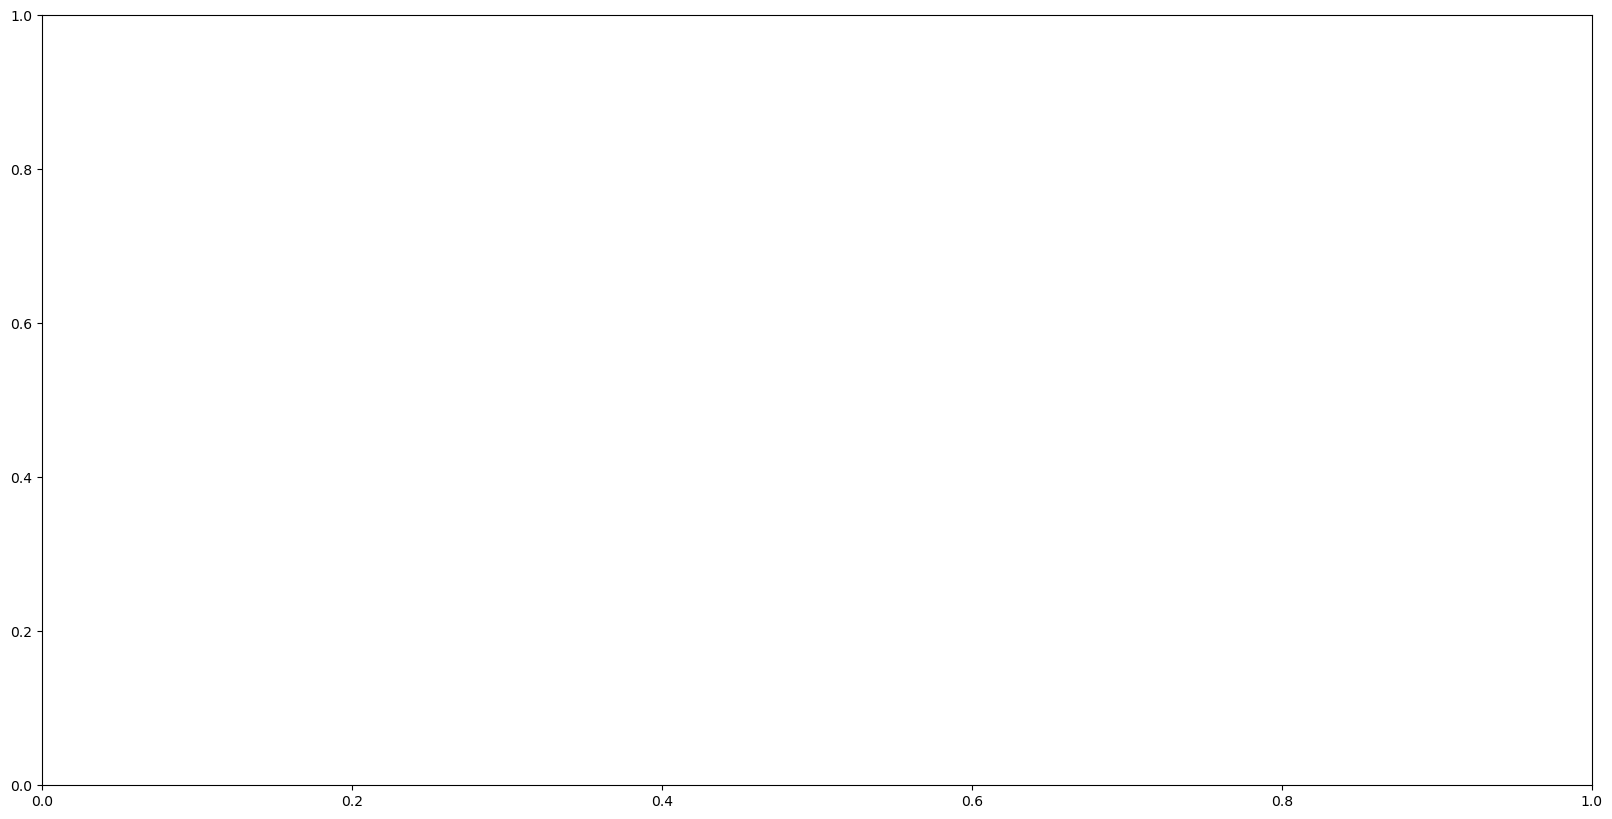

In [30]:
#Windows:
#%cd $opath\ScriptsPlot
#%run ConvergencePlot -f "NrMmtc_SimPerScriptCampaign_UlTdd_Prbs96_ueNumScenario84.yaml" -p $opath\results_cluster_NrMmtc_SimPerScriptCampaign_UlTdd_Prbs96_ueNumScenario84_Lambda

#Linux:
%cd $plots_result_path"PlotScripts"
%run ConvergencePlot -j "10" -f "Placement_Manaus_Case_1_2.yaml" -p '/home/oai-ufrn/Repositories/tests/open_ran_datacenter_placement/Results/results_Placement_Manaus_Case_1_2_odcs/'

In [31]:
pd.set_option('display.max_rows', None)